<a href="https://colab.research.google.com/github/Soguy-fr/MEAL_with_AI/blob/main/Analyse_formulaire_partag%C3%A9_avec_formation_BIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup
Installation

In [ ]:
!pip install langchain
!pip install -qU langchain-openai
!pip install ydata-profiling sweetviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 61.1 MB/s eta 0:00:00


Récupérer les clés API

In [ ]:
from google.colab import userdata
import os

# Ici vous devez enregistrer vos propres clés dans l'onglet "Secret" à gauche
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')


Import main library

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain.output_parsers.json import SimpleJsonOutputParser
import pandas as pd
import json
from IPython.display import display
from IPython.display import IFrame
import sweetviz as sv
import numpy as np
import matplotlib.pyplot as plt





# Debut du code
Ouvrir le fichier CSV et le mettre dans le Dataframe

In [ ]:

# Chargez le fichier Excel de l'enquête
file_path = '/content/RESULTATS DE LENQUETE MODULE 3 (2).xlsx'

# Utilisez pandas pour lire le fichier Excel
df = pd.read_excel(file_path)

# Extraire la colonne Q21
df_q21 = df[['Q21']]

# Convertir la colonne Q21 en une seule chaîne de texte
text_q21 = " ".join(df_q21['Q21'].dropna().astype(str).tolist())

# Afficher les premières lignes de la colonne Q21 pour vérifier le contenu
print(df_q21.head())


                                                 Q21
0  Capacité de piloter les processus de suivi-éva...
1  Trois compétences que je souhaiterais acquérir...
2  Planification du S&amp;E  Mise en oeuvre du S&...
3  -Planification du suivi et de l'évaluation;  -...
4  Connaitre la différence entre hypothèses et ri...


# Identification des compétences

In [ ]:
model_simple = ChatOpenAI(model="gpt-4o-mini")
#model_avancé = ChatOpenAI(model="gpt-4")

json_parser = SimpleJsonOutputParser()

# Définir le prompt pour l'analyse
competence_prompt = PromptTemplate.from_template(
    """
    Voici l'ensemble des réponses d'un formulaire à la question :
    'Veuillez indiquer trois compétences que vous souhaiteriez acquérir grâce à ce cours.' : {responses_text}.
    Ton objectif est d'identifier les principales compétences les plus souvent citées.
    Pour cela tu vas lire toutes les compétences citées et chercher les principales catégories de compétence.
    Assures toi que les compétences que tu as choisies recouvre bien les principales réponses.
    Assures toi que les compétences soient clairement exprimées.
    Assures toi que les compétences sont bien différenciées les unes des autres.
    Tu identifies au maximum 8 compétences et au minimum 4.
    Ta réponse doit être un objet JSON valide avec comme clé le nom de la compétence, et aucun valeur associé.
    Ajoute comme dernière compétence 'Autres'
    """
)


# Exécuter la chaîne
chain = competence_prompt | model_simple | json_parser
JSON_competence = chain.invoke({"responses_text": text_q21})

# Afficher les résultats
print('Proposition de compétences : ')
print(json.dumps(JSON_competence, indent=4, ensure_ascii=False))


{
    "Maitrise des outils et techniques de suivi-évaluation": {},
    "Analyse et interprétation des données": {},
    "Planification et mise en oeuvre de systèmes de suivi-évaluation": {},
    "Gestion des risques et des hypothèses": {},
    "Communication et présentation des résultats": {},
    "Elaboration et rédaction de rapports d'évaluation": {},
    "Conception et utilisation d'indicateurs de performance": {},
    "Autres": {}
}


Facultatif

In [ ]:
# Si les compétences proposé dans le JSON de l'IA ne vous convient pas, vous pouvez la modifier avec le code ci-dessous :

JSON_competence = {
    "Maitrise des outils et techniques de suivi-évaluation": {},
    "Analyse et interprétation des données": {},
    "Planification et mise en oeuvre de systèmes de suivi-évaluation": {},
    "Gestion des risques et des hypothèses": {},
    "Communication et présentation des résultats": {},
    "Elaboration et rédaction de rapports d'évaluation": {},
    "Conception et utilisation d'indicateurs de performance": {},
    "Autres": {}
}

<class 'dict'>


Fonction pour analyser une réponse individuelle

In [ ]:
# Fonction pour analyser une réponse individuelle
def analyze_response(response, JSON_competence):
    prompt_analyse = PromptTemplate.from_template(
        """Voici une réponse d'un participant à la question 'Veuillez indiquer trois compétences que vous souhaiteriez acquérir grâce à ce cours.' = {response}.
        Identifie à quelles compétences cette réponse s'associe (ça peut être une ou plusieurs compétences).
        Ta réponse doit avoir la forme d'un JSON valide. Ton JSON doit avoir les mêmes clés que ce JSON : {JSON_competence}.
        Pour chaque clé, analyse si cette compétence est représentée clairement dans la réponse.
        Si tu ne sais pas quoi répondre, tu choisis 'Autres'.
        Si la compétence est représentée dans la réponse, la valeur de la clé correspondant prend 1, sinon 0."""
    )

    chain_analyse = prompt_analyse | model_simple | json_parser
    output_analyse = chain_analyse.invoke({
        "response": response,
        "JSON_competence": JSON_competence
    })

    return output_analyse

In [ ]:
# Liste pour stocker les résultats
results = []

# Parcourir les cinq premières réponses pour l'analyse
#for response in df_q21['Q21'].dropna().head(5):
for response in df_q21['Q21'].dropna():
    # Effectuer l'analyse de la réponse
    analysis_result = analyze_response(response, JSON_competence)

    # Ajouter la réponse au début du dictionnaire de résultats
    analysis_result["Réponse du participant"] = response

    # Appliquer une structure plate au dictionnaire si nécessaire (exemple: { "compétence": 1 })
    for key in analysis_result:
        if isinstance(analysis_result[key], dict) and 'value' in analysis_result[key]:
            analysis_result[key] = analysis_result[key]['value']

    # Ajouter l'analyse au tableau des résultats
    results.append(analysis_result)

# Convertir la liste des résultats en DataFrame
df_results = pd.DataFrame(results)

# Réorganiser les colonnes pour mettre la réponse en premier
columns_order = ["Réponse du participant"] + list(JSON_competence.keys())
df_results = df_results.reindex(columns=columns_order, fill_value=0)

# Afficher le tableau
display(df_results)


,Réponse du participant,Maitrise des outils et techniques de suivi-évaluation,Analyse et interprétation des données,Planification et mise en oeuvre de systèmes de suivi-évaluation,Gestion des risques et des hypothèses,Communication et présentation des résultats,Elaboration et rédaction de rapports d'évaluation,Conception et utilisation d'indicateurs de performance,Autres
0,Capacité de piloter les processus de suivi-éva...,1,0,1,0,1,0,0,0
1,Trois compétences que je souhaiterais acquérir...,1,1,0,0,1,1,0,0
2,Planification du S&amp;E Mise en oeuvre du S&...,0,0,1,0,0,0,0,0
3,-Planification du suivi et de l'évaluation; -...,0,0,1,0,0,0,0,0
4,Connaitre la différence entre hypothèses et ri...,{'compétence_représentée': 0},{'compétence_représentée': 1},{'compétence_représentée': 0},{'compétence_représentée': 1},{'compétence_représentée': 0},{'compétence_représentée': 0},{'compétence_représentée': 0},{'compétence_représentée': 0}
5,Mettre en place un système de suivi-évaluation...,0,0,1,0,0,0,0,0
6,Compétence en conception de plan de suivi-éval...,1,1,1,0,0,0,0,0
7,Connaitre le vocabulaire et les pratiques du s...,0,1,0,0,0,0,0,0
8,Matriser les compétences pratiques pour l'éval...,0,0,0,1,0,0,0,0
9,conception d'un projet/programme Maitris...,1,0,1,0,0,0,1,0


In [ ]:

# Sauvegarder le DataFrame en fichier Excel
df_results.to_excel('/content/df_results.xlsx', index=False)

# Importer Google Drive pour enregistrer le fichier dans Drive
from google.colab import drive
drive.mount('/content/drive')  # Monter votre Google Drive

# Copier le fichier dans votre Drive
!cp /content/df_results.xlsx "/content/drive/MyDrive/02 - R&D/01 - Renforcement de capacité/01 - MOOC suivis/12 - M&E BIT/Module 4"
print("Fichier enregistré dans Google Drive sous /MyDrive/df_results.xlsx")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fichier enregistré dans Google Drive sous /MyDrive/df_results.xlsx


# Analyse

Nettoyage des données

In [ ]:
# Prétraiter pour remplacer les dictionnaires par NaN, et garder seulement les entiers 0 ou 1
for col in df_results.columns:
    if col != "Réponse du participant":  # Ignorer la colonne des réponses textuelles
        # Remplacer les dictionnaires et les valeurs non numériques par NaN
        df_results[col] = df_results[col].apply(lambda x: x['value'] if isinstance(x, dict) and 'value' in x else x)
        df_results[col] = pd.to_numeric(df_results[col], errors='coerce')  # Convertit en NaN les valeurs non numériques
        df_results[col] = df_results[col].apply(lambda x: x if x in [0, 1] else np.nan)

# Supprimer les lignes avec NaN si nécessaire
df_results.dropna(inplace=True)


Comptabilisation du nombre de compétences et affichage des résultats

Nombre de réponses avec '1' pour chaque compétence, trié du plus grand au plus petit :
Planification et mise en oeuvre de systèmes de suivi-évaluation    39.0
Maitrise des outils et techniques de suivi-évaluation              30.0
Analyse et interprétation des données                              21.0
Conception et utilisation d'indicateurs de performance             15.0
Communication et présentation des résultats                        13.0
Gestion des risques et des hypothèses                              10.0
Elaboration et rédaction de rapports d'évaluation                   9.0
Autres                                                              1.0
dtype: float64


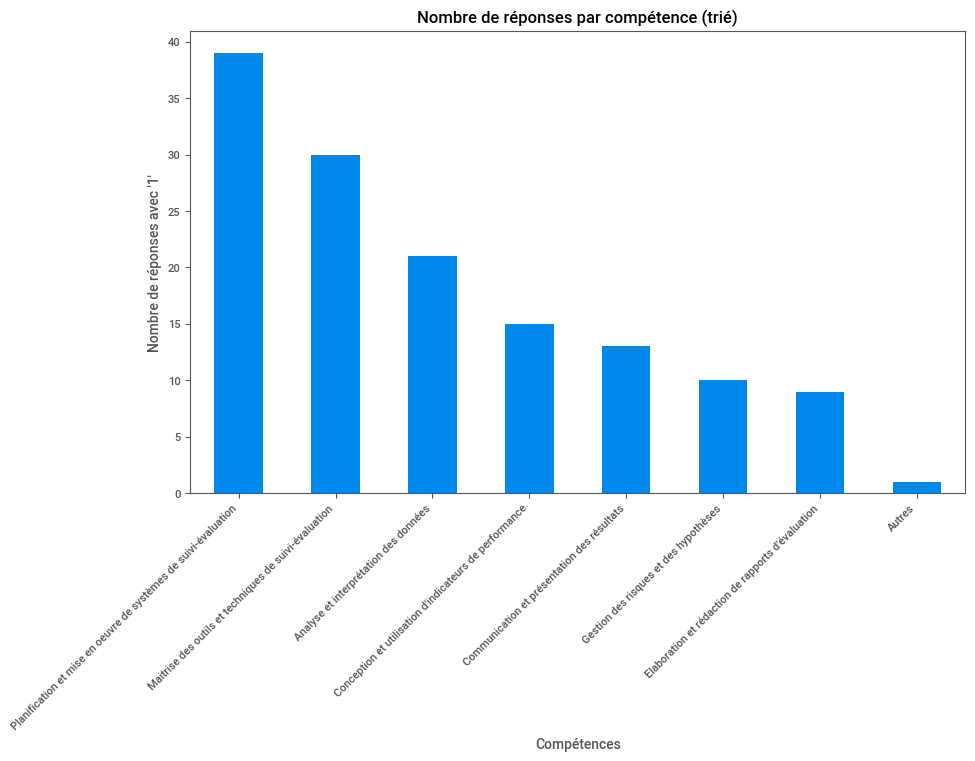

In [ ]:
# Calculer la somme de chaque compétence (le nombre de fois où chaque compétence a été choisie)
competence_sums = df_results.drop(columns=["Réponse du participant"]).sum().sort_values(ascending=False)

# 1. Afficher le tableau
print("Nombre de réponses avec '1' pour chaque compétence, trié du plus grand au plus petit :")
print(competence_sums)

# 2. Créer un histogramme trié du plus grand au plus petit
plt.figure(figsize=(10, 6))
competence_sums.plot(kind='bar')
plt.title("Nombre de réponses par compétence (trié)")
plt.xlabel("Compétences")
plt.ylabel("Nombre de réponses avec '1'")
plt.xticks(rotation=45, ha="right")
plt.show()